<h2><프로젝트 목표><br>
로지스틱 회귀 분석 및 의사 결정 트리를 사용하여 포지션 별 LOL게임결과 예측

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns

#Python 시각화 라이브러리
import plotly.express as px

from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics #예측오류를 평가


In [ ]:
kr_data = pd.read_csv('KR_challengergame_Jan2022.csv', index_col=0)

In [ ]:
kr_data.head()

,d_spell,f_spell,champion,side,role,assists,damage_objectives,damage_building,damage_turrets,deaths,...,kda,kills,level,time_cc,damage_total,damage_taken,total_minions_killed,turret_kills,vision_score,result
0,14,4,Leona,Side.blue,Lane.utility,6,0,0,0,6,...,1.333333,2,9,23,15214,9404,36,0,47,False
1,11,4,Udyr,Side.red,Lane.jungle,8,547,46480,547,3,...,6.666667,12,16,32,194463,25782,23,1,20,True
2,14,4,Xerath,Side.red,Lane.utility,2,168,444,168,7,...,0.285714,0,10,22,34038,14079,26,0,38,False
3,14,4,Zoe,Side.red,Lane.mid_lane,8,2492,3082,2492,3,...,5.000000,7,14,29,94369,11128,133,2,17,True
4,4,12,Camille,Side.red,Lane.top_lane,8,6419,7408,6419,5,...,4.200000,13,15,25,110580,20404,141,2,24,True


In [ ]:
kr_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5697 entries, 0 to 5696
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   d_spell               5697 non-null   int64  
 1   f_spell               5697 non-null   int64  
 2   champion              5697 non-null   object 
 3   side                  5697 non-null   object 
 4   role                  5697 non-null   object 
 5   assists               5697 non-null   int64  
 6   damage_objectives     5697 non-null   int64  
 7   damage_building       5697 non-null   int64  
 8   damage_turrets        5697 non-null   int64  
 9   deaths                5697 non-null   int64  
 10  gold_earned           5697 non-null   int64  
 11  kda                   5697 non-null   float64
 12  kills                 5697 non-null   int64  
 13  level                 5697 non-null   int64  
 14  time_cc               5697 non-null   int64  
 15  damage_total         

In [ ]:
kr_data['f_spell'] = kr_data['f_spell'].astype(object)
kr_data['d_spell'] = kr_data['d_spell'].astype(object)

데이터들을 각 포지션 별로 나누기

In [ ]:
#탑
top_data = kr_data[kr_data['role'] == 'Lane.top_lane']
#정글
jungle_data = kr_data[kr_data['role'] == 'Lane.jungle']
#미드
mid_data = kr_data[kr_data['role'] == 'Lane.mid_lane']
#원딜
adc_data = kr_data[kr_data['role'] == 'Lane.bot_lane']
#서포터
support_data = kr_data[kr_data['role'] == 'Lane.utility']

각 포지션 별 챔피언 선택 분포

In [ ]:
px.histogram(top_data, x='champion',
             title='탑 챔피언 분포').update_xaxes(categoryorder='total descending')

In [ ]:
px.histogram(jungle_data, x='champion',
             title='정글 챔피언 분포').update_xaxes(categoryorder='total descending')

In [ ]:
px.histogram(mid_data, x='champion',
             title='미드 챔피언 분포').update_xaxes(categoryorder='total descending')

In [ ]:
px.histogram(adc_data, x='champion',
             title='원딜 챔피언 분포').update_xaxes(categoryorder='total descending')

In [ ]:
px.histogram(support_data, x='champion',
             title='서포터 챔피언 분포').update_xaxes(categoryorder='total descending')

damage_turrets과 damage_objectives의 값이 같으므로 하나를 제거해준다

In [ ]:
top_data = top_data.drop(['damage_turrets'], axis=1)
jungle_data = jungle_data.drop(['damage_turrets'], axis=1)
mid_data = mid_data.drop(['damage_turrets'], axis=1)
adc_data = adc_data.drop(['damage_turrets'], axis=1)
support_data = support_data.drop(['damage_turrets'], axis=1)

승률 분석에 필요한 column만 남긴다 (승패에 영향을 끼치지 않는 요소 제거)

In [ ]:
top_data_final = top_data.drop(['champion','role', 'd_spell', 'f_spell'], axis=1)
jungle_data_final = jungle_data.drop(['champion','role', 'd_spell', 'f_spell'], axis=1)
mid_data_final = mid_data.drop(['champion','role', 'd_spell', 'f_spell'], axis=1)
adc_data_final = adc_data.drop(['champion','role', 'd_spell', 'f_spell'], axis=1)
support_data_final = support_data.drop(['champion','role', 'd_spell', 'f_spell'], axis=1)

3가지 모델을 생성
1. Logistic 회귀
2. 의사결정트리
3. 랜덤 포레스트

교차검증방식 : Repeated K-Fold

Repeated K-Fold란?
-  전체 데이터를 임의로 나누어서 validation set을 한 번씩 번갈아가면서 데이터셋을 구성

- 각 데이터를 학습하고 validation으로 평가를 한 다음 K개의 결과에 대해 평균을 내어 최종 성능을 구함

F1 score
 - Accuracy(정확도) - 전체 클래스 중 True는 True로 False는 False로 잘 예측했는지?
 - Precision(정밀도) - 모델이 True로 예측한 값들 중에서 정말로 예측한 값이 맞는지?
 - Recall(재현율) -  True 클래스 중 모델이 잘 예측한 클래스의 비율?
 - F1 Score = 2 X (정밀도 X 재현율) / (정밀도 + 재현율)<br>
정밀도와 재현율을 결합한 지표(F1 Score는 정밀도와 재현율이 어느 한쪽으로 치우치지 않는 수치를 나타낼 때 상대적으로 높은 값을 가짐)
<br>

ROC curve 
- Recall과 FPR (False Positive Rate - 전체 Negative 데이터 중 모델이 얼마나 Positive로 잘못 예측했는지)를 사용
- 1에 가까울수록 분류가 잘 이루어지고 0.5에 가까울수록 분류가 잘 안 이루어짐

탑

Label Encoding

In [ ]:
# 1: 레드팀, 0: 블루팀
top_data_final['side'] = top_data_final['side'].map({'Side.red': 1, 'Side.blue':0})

# 1: 승리, 0: 패배
top_data_final['result'] = top_data_final['result'].map({True: 1, False:0})

In [ ]:
#체크
top_data_final.head(3)

,side,assists,damage_objectives,damage_building,deaths,gold_earned,kda,kills,level,time_cc,damage_total,damage_taken,total_minions_killed,turret_kills,vision_score,result
4,1,8,6419,7408,5,12368,4.200000,13,15,25,110580,20404,141,2,24,1
14,0,3,4207,5705,4,9121,1.750000,4,13,12,102586,20290,153,2,6,0
18,1,9,5276,17111,9,18569,2.333333,12,18,10,254391,32040,273,0,27,0


In [ ]:
# 80-20 train-test split
X_top = top_data_final.drop(columns=['result']).values
Y_top = top_data_final['result'].values
X_train_top, X_test_top, Y_train_top, Y_test_top = train_test_split(X_top,Y_top,test_size=0.2, random_state=2022)

In [ ]:
#각 데이터를 학습하고 validation으로 평가를 한 다음 10개의 결과에 대해 평균을 내어 최종 성능을 구함
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=2022)

In [ ]:
#로지스틱 회귀
top_log_model = LogisticRegression(random_state=2022, max_iter=10000)
top_log_model.fit(X_train_top,Y_train_top)

LogisticRegression(max_iter=10000, random_state=2022)

In [ ]:
top_log_f1scores = cross_val_score(top_log_model, X_train_top, Y_train_top, scoring="f1",cv=cv)

In [ ]:
top_log_ROCscores = cross_val_score(top_log_model, X_train_top, Y_train_top, scoring="roc_auc", cv=cv)

In [ ]:
print('F1: %.3f (%.3f)' % (np.mean(top_log_f1scores), np.std(top_log_f1scores)))
print('ROC: %.3f (%.3f)' % (np.mean(top_log_ROCscores), np.std(top_log_ROCscores)))

F1: 0.822 (0.048)
ROC: 0.905 (0.033)


In [ ]:
#의사결정트리
top_dt_model = DecisionTreeClassifier(random_state=2022)
top_dt_model.fit(X_train_top,Y_train_top)

DecisionTreeClassifier(random_state=2022)

In [ ]:
top_dt_f1scores = cross_val_score(top_dt_model, X_train_top, Y_train_top, 
                                    scoring="f1",cv=cv)
top_dt_ROCscores = cross_val_score(top_dt_model, X_train_top, Y_train_top,
                                       scoring="roc_auc", cv=cv)

In [ ]:
print('F1: %.3f (%.3f)' % (np.mean(top_dt_f1scores), np.std(top_dt_f1scores)))
print('ROC: %.3f (%.3f)' % (np.mean(top_dt_ROCscores), np.std(top_dt_ROCscores)))

F1: 0.800 (0.038)
ROC: 0.794 (0.038)


In [ ]:
#랜덤포레스트
top_rf_model = RandomForestClassifier(random_state = 2022)
top_rf_model.fit(X_train_top,Y_train_top)

RandomForestClassifier(random_state=2022)

In [ ]:
top_rf_f1scores = cross_val_score(top_rf_model, X_train_top, Y_train_top, scoring="f1",cv=cv)

top_rf_ROCscores = cross_val_score(top_rf_model, X_train_top, Y_train_top, scoring="roc_auc", cv=cv)

In [ ]:
print('F1: %.3f (%.3f)' % (np.mean(top_rf_f1scores), np.std(top_rf_f1scores)))
print('ROC: %.3f (%.3f)' % (np.mean(top_rf_ROCscores), np.std(top_rf_ROCscores)))

F1: 0.856 (0.035)
ROC: 0.923 (0.031)


Random Forest가 가장 잘 수행하였으므로 Random Forest를 test set으로 사용

예측

In [ ]:
y_top_predict = top_rf_model.predict(X_test_top)

In [ ]:
print("Accuracy Score", metrics.accuracy_score(Y_test_top, y_top_predict))
print("F1 Score", metrics.f1_score(Y_test_top, y_top_predict))
print("ROC-AUC Score", metrics.roc_auc_score(Y_test_top, y_top_predict))

Accuracy Score 0.8253275109170306
F1 Score 0.8387096774193549
ROC-AUC Score 0.8232415902140673


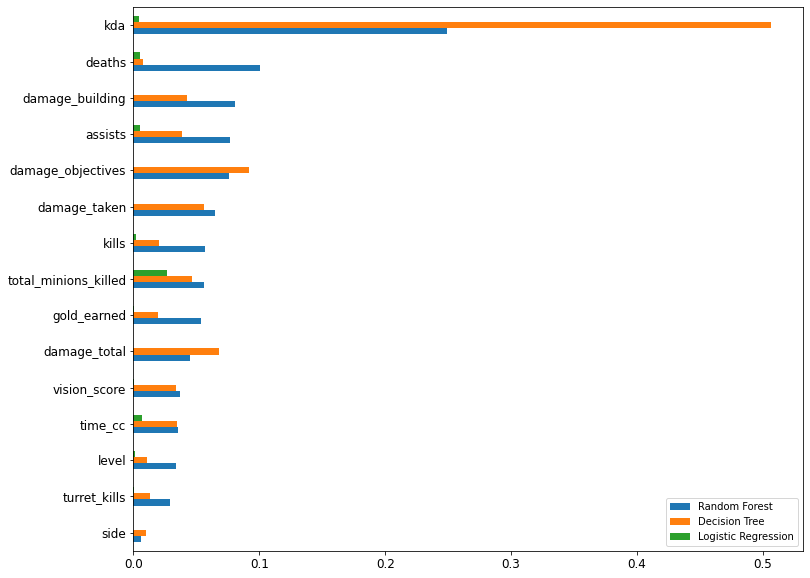

In [ ]:
top_feature_importance=pd.DataFrame({
    'Random Forest':top_rf_model.feature_importances_,
    'Decision Tree':top_dt_model.feature_importances_,
    'Logistic Regression':[abs(i) for i in top_log_model.coef_[0]]
},index=top_data_final.drop(columns=['result']).columns)
top_feature_importance.sort_values(by='Random Forest',ascending=True,inplace=True)

top_feature_importance.plot(kind='barh',figsize=(12,10),fontsize=12)

Random Forest모델과 Decision Tree모델은  KDA에 중점을 두었고, 
<br>로지스틱 회귀 모델은 total_minions_killed에 중점으로 두었다는 것을 볼 수 있다.

정글

Label Encoding

In [ ]:
# 1: 레드팀, 0: 블루팀
jungle_data_final['side'] = jungle_data_final['side'].map({'Side.red': 1, 'Side.blue':0})

# 1: 승리, 0: 패배
jungle_data_final['result'] = jungle_data_final['result'].map({True: 1, False:0})

In [ ]:
#체크
jungle_data_final.head(3)

,side,assists,damage_objectives,damage_building,deaths,gold_earned,kda,kills,level,time_cc,damage_total,damage_taken,total_minions_killed,turret_kills,vision_score,result
1,1,8,547,46480,3,12919,6.666667,12,16,32,194463,25782,23,1,20,1
9,0,2,1322,14485,7,10050,1.428571,8,12,14,110857,25643,24,1,24,0
11,1,2,0,6259,5,6614,0.800000,2,11,11,96989,16934,12,0,21,0


In [ ]:
# 80-20 train test split
X_jungle = jungle_data_final.drop(columns=['result']).values
Y_jungle = jungle_data_final['result'].values
X_train_jungle, X_test_jungle, Y_train_jungle,Y_test_jungle = train_test_split(X_jungle,Y_jungle,test_size=0.2, random_state=2022)

In [ ]:
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=2022)

In [ ]:
#로지스틱 회귀
jungle_log_model = LogisticRegression(random_state=2022, max_iter=10000)
jungle_log_model.fit(X_train_jungle,Y_train_jungle)

LogisticRegression(max_iter=10000, random_state=2022)

In [ ]:
jungle_log_f1scores = cross_val_score(jungle_log_model, X_train_jungle, Y_train_jungle, scoring="f1",cv=cv)

jungle_log_ROCscores = cross_val_score(jungle_log_model, X_train_jungle, Y_train_jungle, scoring="roc_auc", cv=cv)

In [ ]:
print('F1: %.3f (%.3f)' % (np.mean(jungle_log_f1scores), np.std(jungle_log_f1scores)))
print('ROC: %.3f (%.3f)' % (np.mean(jungle_log_ROCscores), np.std(jungle_log_ROCscores)))

F1: 0.870 (0.030)
ROC: 0.939 (0.023)


In [ ]:
#의사결정트리
jungle_dt_model = DecisionTreeClassifier(random_state=2022)
jungle_dt_model.fit(X_train_jungle,Y_train_jungle)

DecisionTreeClassifier(random_state=2022)

In [ ]:
jungle_dt_f1scores = cross_val_score(jungle_dt_model, X_train_jungle, Y_train_jungle, scoring="f1",cv=cv)

jungle_dt_ROCscores = cross_val_score(jungle_dt_model, X_train_jungle, Y_train_jungle, scoring="roc_auc", cv=cv)

In [ ]:
print('F1: %.3f (%.3f)' % (np.mean(jungle_dt_f1scores), np.std(jungle_dt_f1scores)))
print('ROC: %.3f (%.3f)' % (np.mean(jungle_dt_ROCscores), np.std(jungle_dt_ROCscores)))

F1: 0.831 (0.037)
ROC: 0.820 (0.039)


In [ ]:
#랜덤포레스트
jungle_rf_model = RandomForestClassifier(random_state = 2022)
jungle_rf_model.fit(X_train_jungle,Y_train_jungle)

RandomForestClassifier(random_state=2022)

In [ ]:
jungle_rf_f1scores = cross_val_score(jungle_rf_model, X_train_jungle, Y_train_jungle, scoring="f1",cv=cv)

jungle_rf_ROCscores = cross_val_score(jungle_rf_model, X_train_jungle, Y_train_jungle, scoring="roc_auc", cv=cv)

In [ ]:
print('F1: %.3f (%.3f)' % (np.mean(jungle_rf_f1scores), np.std(jungle_rf_f1scores)))
print('ROC: %.3f (%.3f)' % (np.mean(jungle_rf_ROCscores), np.std(jungle_rf_ROCscores)))

F1: 0.888 (0.025)
ROC: 0.953 (0.020)


Random Forest가 가장 잘 수행하였으므로 Random Forest를 test set으로 사용

예측

In [ ]:
y_jungle_predict = jungle_rf_model.predict(X_test_jungle)

In [ ]:
print("Accuracy Score", metrics.accuracy_score(Y_test_jungle, y_jungle_predict))
print("F1 Score", metrics.f1_score(Y_test_jungle, y_jungle_predict))
print("ROC-AUC Score", metrics.roc_auc_score(Y_test_jungle, y_jungle_predict))

Accuracy Score 0.8652173913043478
F1 Score 0.8713692946058091
ROC-AUC Score 0.8679309561662504


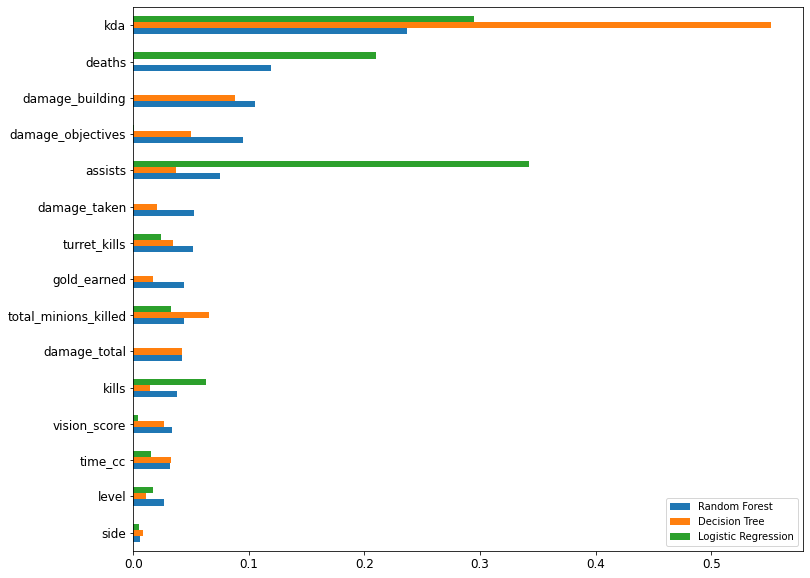

In [ ]:
jungle_feature_importance=pd.DataFrame({
    'Random Forest':jungle_rf_model.feature_importances_,
    'Decision Tree':jungle_dt_model.feature_importances_,
    'Logistic Regression':[abs(i) for i in jungle_log_model.coef_[0]]
},index=jungle_data_final.drop(columns=['result']).columns)
jungle_feature_importance.sort_values(by='Random Forest',ascending=True,inplace=True)

jungle_feature_importance.plot(kind='barh',figsize=(12,10),fontsize=12)

세 모델 모두 KDA에 중점을 두었고, 의사 결정 트리가 가장 많은 중점을 두었다.
로지스틱 회귀 모델은 level,assists,kills,deaths도 중점으로 두었다는 것을 볼 수 있다.

미드

Label Encoding

In [ ]:
# 1: 레드팀, 0: 블루팀
mid_data_final['side'] = mid_data_final['side'].map({'Side.red': 1, 'Side.blue':0})

# 1: 승리, 0: 패배
mid_data_final['result'] = mid_data_final['result'].map({True: 1, False:0})

In [ ]:
#체크
mid_data_final.head(3)

,side,assists,damage_objectives,damage_building,deaths,gold_earned,kda,kills,level,time_cc,damage_total,damage_taken,total_minions_killed,turret_kills,vision_score,result
3,1,8,2492,3082,3,10688,5.0,7,14,29,94369,11128,133,2,17,1
8,0,10,7724,9580,4,10734,5.0,10,14,27,116207,28866,156,2,11,1
15,1,0,0,0,10,5187,0.0,0,10,5,56950,18866,126,0,10,0


In [ ]:
# 80-20 train test split
X_mid = mid_data_final.drop(columns=['result']).values
Y_mid = mid_data_final['result'].values
X_train_mid, X_test_mid, Y_train_mid, Y_test_mid = train_test_split(X_mid,Y_mid,test_size=0.2, random_state=2022)

In [ ]:
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=2022)

In [ ]:
#로지스틱 회귀
mid_log_model = LogisticRegression(random_state=2022, max_iter=10000)
mid_log_model.fit(X_train_mid,Y_train_mid)

LogisticRegression(max_iter=10000, random_state=2022)

In [ ]:
mid_log_f1scores = cross_val_score(mid_log_model, X_train_mid, Y_train_mid, scoring="f1",cv=cv)

In [ ]:
mid_log_ROCscores = cross_val_score(mid_log_model, X_train_mid, Y_train_mid, scoring="roc_auc", cv=cv)

In [ ]:
print('F1: %.3f (%.3f)' % (np.mean(mid_log_f1scores), np.std(mid_log_f1scores)))
print('ROC: %.3f (%.3f)' % (np.mean(mid_log_ROCscores), np.std(mid_log_ROCscores)))

F1: 0.826 (0.060)
ROC: 0.914 (0.037)


In [ ]:
#의사결정트리
mid_dt_model = DecisionTreeClassifier(random_state=2022)
mid_dt_model.fit(X_train_mid,Y_train_mid)

DecisionTreeClassifier(random_state=2022)

In [ ]:
mid_dt_f1scores = cross_val_score(mid_dt_model, X_train_mid, Y_train_mid, scoring="f1",cv=cv)
mid_dt_ROCscores = cross_val_score(mid_dt_model, X_train_mid, Y_train_mid, scoring="roc_auc", cv=cv)

In [ ]:
print('F1: %.3f (%.3f)' % (np.mean(mid_dt_f1scores), np.std(mid_dt_f1scores)))
print('ROC: %.3f (%.3f)' % (np.mean(mid_dt_ROCscores), np.std(mid_dt_ROCscores)))

F1: 0.765 (0.048)
ROC: 0.781 (0.041)


In [ ]:
#랜덤포레스트
mid_rf_model = RandomForestClassifier(random_state = 2022)
mid_rf_model.fit(X_train_mid,Y_train_mid)

RandomForestClassifier(random_state=2022)

In [ ]:
mid_rf_f1scores = cross_val_score(mid_rf_model, X_train_mid, Y_train_mid, scoring="f1",cv=cv)

mid_rf_ROCscores = cross_val_score(mid_rf_model, X_train_mid, Y_train_mid, scoring="roc_auc", cv=cv)

In [ ]:
print('F1: %.3f (%.3f)' % (np.mean(mid_rf_f1scores), np.std(mid_rf_f1scores)))
print('ROC: %.3f (%.3f)' % (np.mean(mid_rf_ROCscores), np.std(mid_rf_ROCscores)))

F1: 0.826 (0.042)
ROC: 0.928 (0.027)


Random Forest가 가장 잘 수행하였으므로 Random Forest를 test set으로 사용

예측

In [ ]:
y_mid_predict = mid_rf_model.predict(X_test_mid)

In [ ]:
print("Accuracy Score", metrics.accuracy_score(Y_test_mid, y_mid_predict))
print("F1 Score", metrics.f1_score(Y_test_mid, y_mid_predict))
print("ROC-AUC Score", metrics.roc_auc_score(Y_test_mid, y_mid_predict))

Accuracy Score 0.8185840707964602
F1 Score 0.7918781725888325
ROC-AUC Score 0.8141386138613862


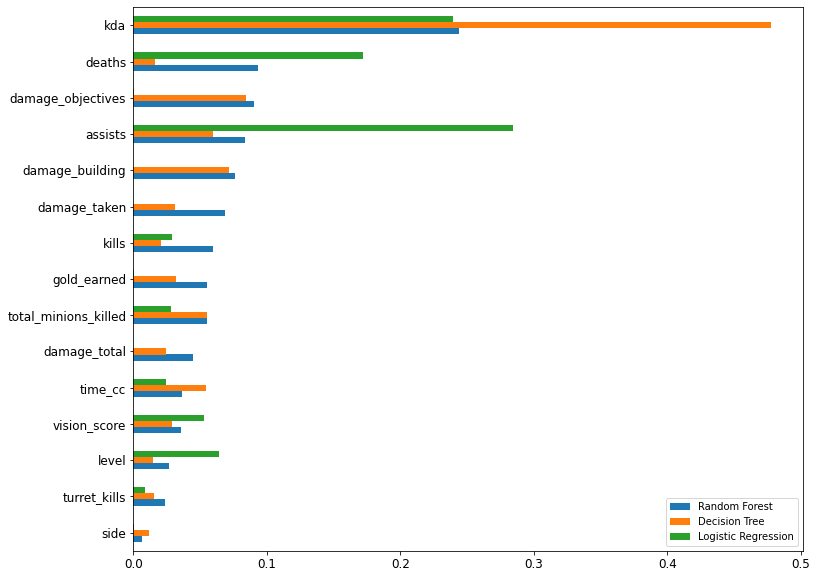

In [ ]:
mid_feature_importance=pd.DataFrame({
    'Random Forest':mid_rf_model.feature_importances_,
    'Decision Tree':mid_dt_model.feature_importances_,
    'Logistic Regression':[abs(i) for i in mid_log_model.coef_[0]]
},index=mid_data_final.drop(columns=['result']).columns)
mid_feature_importance.sort_values(by='Random Forest',ascending=True,inplace=True)

mid_feature_importance.plot(kind='barh',figsize=(12,10),fontsize=12)

세 모델 모두 KDA에 중점을 두었고, 의사 결정 트리가 가장 많은 중점을 두었다.<br>
로지스틱 회귀 모델은 level,assists,kills,deaths도 중점으로 두었다는 것을 볼 수 있다.

원딜

Label Encoding

In [ ]:
# 1: 레드팀, 0: 블루팀
adc_data_final['side'] = adc_data_final['side'].map({'Side.red': 1, 'Side.blue':0})

# 1: 승리, 0: 패배
adc_data_final['result'] = adc_data_final['result'].map({True: 1, False:0})

In [ ]:
#체크
adc_data_final.head(3)

,side,assists,damage_objectives,damage_building,deaths,gold_earned,kda,kills,level,time_cc,damage_total,damage_taken,total_minions_killed,turret_kills,vision_score,result
7,1,9,3657,16688,5,16108,3.600000,9,17,18,244314,20799,262,2,38,0
10,0,2,459,2081,9,5453,0.444444,2,9,12,46588,13083,94,0,7,0
12,0,2,1123,1123,9,9756,0.888889,6,12,15,87263,14887,125,1,12,0


In [ ]:
# 80-20 train-test split
X_adc = adc_data_final.drop(columns=['result']).values
Y_adc = adc_data_final['result'].values
X_train_adc, X_test_adc, Y_train_adc, Y_test_adc = train_test_split(X_adc,Y_adc,test_size=0.2, random_state=2022)

In [ ]:
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=2022)

In [ ]:
#로지스틱 회귀
adc_log_model = LogisticRegression(random_state=2022, max_iter=10000)
adc_log_model.fit(X_train_adc,Y_train_adc)

LogisticRegression(max_iter=10000, random_state=2022)

In [ ]:
adc_log_f1scores = cross_val_score(adc_log_model, X_train_adc, Y_train_adc, scoring="f1",cv=cv)

adc_log_ROCscores = cross_val_score(adc_log_model, X_train_adc, Y_train_adc, scoring="roc_auc", cv=cv)

In [ ]:
print('F1: %.3f (%.3f)' % (np.mean(adc_log_f1scores), np.std(adc_log_f1scores)))
print('ROC: %.3f (%.3f)' % (np.mean(adc_log_ROCscores), np.std(adc_log_ROCscores)))

F1: 0.861 (0.041)
ROC: 0.932 (0.027)


In [ ]:
#의사결정트리
adc_dt_model = DecisionTreeClassifier(random_state=2022)
adc_dt_model.fit(X_train_adc,Y_train_adc)

DecisionTreeClassifier(random_state=2022)

In [ ]:
adc_dt_f1scores = cross_val_score(adc_dt_model, X_train_adc, Y_train_adc, 
                                    scoring="f1",cv=cv)
adc_dt_ROCscores = cross_val_score(adc_dt_model, X_train_adc, Y_train_adc,
                                       scoring="roc_auc", cv=cv)

In [ ]:
print('F1: %.3f (%.3f)' % (np.mean(adc_dt_f1scores), np.std(adc_dt_f1scores)))
print('ROC: %.3f (%.3f)' % (np.mean(adc_dt_ROCscores), np.std(adc_dt_ROCscores)))

F1: 0.817 (0.052)
ROC: 0.825 (0.044)


In [ ]:
#랜덤포레스트
adc_rf_model = RandomForestClassifier(random_state = 2022)
adc_rf_model.fit(X_train_adc,Y_train_adc)

RandomForestClassifier(random_state=2022)

In [ ]:
adc_rf_f1scores = cross_val_score(adc_rf_model, X_train_adc, Y_train_adc, scoring="f1",cv=cv)

adc_rf_ROCscores = cross_val_score(adc_rf_model, X_train_adc, Y_train_adc, scoring="roc_auc", cv=cv)

In [ ]:
print('F1: %.3f (%.3f)' % (np.mean(adc_rf_f1scores), np.std(adc_rf_f1scores)))
print('ROC: %.3f (%.3f)' % (np.mean(adc_rf_ROCscores), np.std(adc_rf_ROCscores)))

F1: 0.869 (0.050)
ROC: 0.952 (0.020)


Random Forest가 가장 잘 수행하였으므로 Random Forest를 test set으로 사용

예측

In [ ]:
y_adc_predict = adc_rf_model.predict(X_test_adc)

In [ ]:
print("Accuracy Score", metrics.accuracy_score(Y_test_adc, y_adc_predict))
print("F1 Score", metrics.f1_score(Y_test_adc, y_adc_predict))
print("ROC-AUC Score", metrics.roc_auc_score(Y_test_adc, y_adc_predict))

Accuracy Score 0.911504424778761
F1 Score 0.9130434782608695
ROC-AUC Score 0.9116771159874608


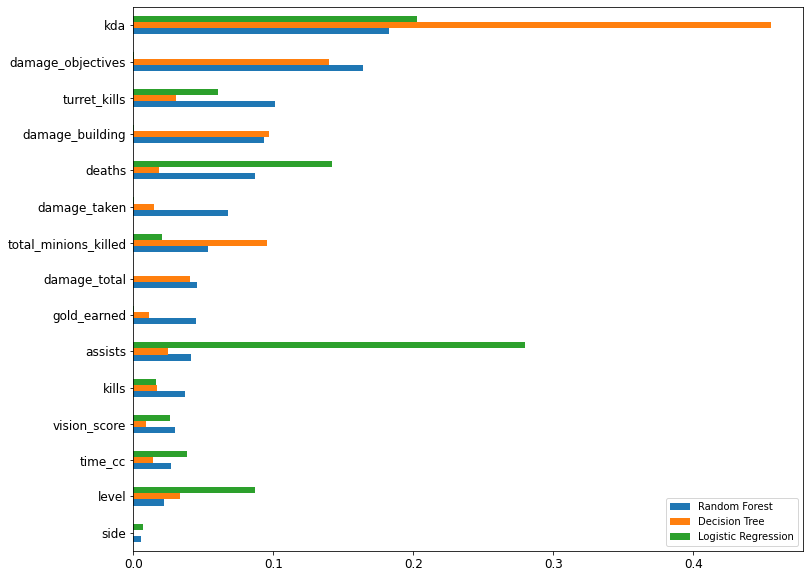

In [ ]:
#feature_importances_ 변수 중요도 추출
adc_feature_importance=pd.DataFrame({
    'Random Forest':adc_rf_model.feature_importances_,
    'Decision Tree':adc_dt_model.feature_importances_,
    'Logistic Regression':[abs(i) for i in adc_log_model.coef_[0]]
},index=adc_data_final.drop(columns=['result']).columns)
adc_feature_importance.sort_values(by='Random Forest',ascending=True,inplace=True)

adc_feature_importance.plot(kind='barh',figsize=(12,10),fontsize=12)

세 모델 모두 KDA에 중점을 두었고, 의사 결정 트리가 가장 많은 중점을 두었다.<br>
로지스틱 회귀 모델은 level,assists,kills,deaths도 중점으로 두었다는 것을 볼 수 있다.

서포터

Label Encoding

In [ ]:
# 1: 레드팀, 0: 블루팀
support_data_final['side'] = support_data_final['side'].map({'Side.red': 1, 'Side.blue':0})

# 1: 승리, 0: 패배
support_data_final['result'] = support_data_final['result'].map({True: 1, False:0})

In [ ]:
#체크
support_data_final.head(3)

,side,assists,damage_objectives,damage_building,deaths,gold_earned,kda,kills,level,time_cc,damage_total,damage_taken,total_minions_killed,turret_kills,vision_score,result
0,0,6,0,0,6,6043,1.333333,2,9,23,15214,9404,36,0,47,0
2,1,2,168,444,7,5641,0.285714,0,10,22,34038,14079,26,0,38,0
5,1,14,625,1144,3,6471,5.000000,1,11,37,17852,11112,25,0,30,1


In [ ]:
# 80-20 train-test split
X_support = support_data_final.drop(columns=['result']).values
Y_support = support_data_final['result'].values
X_train_support, X_test_support, Y_train_support, Y_test_support = train_test_split(X_support,Y_support,test_size=0.2, random_state=2022)

In [ ]:
#RepeatedKFold - 폴드를 한번만 나누는 것이 아니고 지정한 횟수(n_repeats)만큼 반복해서 나누게 되고 교차검증점수도 반복한 만큼 얻을 수 있다.
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=2022)

In [ ]:
#로지스틱 회귀
support_log_model = LogisticRegression(random_state=2022, max_iter=10000)
support_log_model.fit(X_train_support,Y_train_support)

LogisticRegression(max_iter=10000, random_state=2022)

In [ ]:
support_log_f1scores = cross_val_score(support_log_model, X_train_support, Y_train_support, 
                                       scoring="f1",cv=cv)

support_log_ROCscores = cross_val_score(support_log_model, X_train_support, Y_train_support,
                                        scoring="roc_auc", cv=cv)

In [ ]:
print('F1: %.3f (%.3f)' % (np.mean(support_log_f1scores), np.std(support_log_f1scores)))
print('ROC: %.3f (%.3f)' % (np.mean(support_log_ROCscores), np.std(support_log_ROCscores)))

F1: 0.835 (0.041)
ROC: 0.912 (0.027)


In [ ]:
#의사결정트리
support_dt_model = DecisionTreeClassifier(random_state=2022)
support_dt_model.fit(X_train_support,Y_train_support)

DecisionTreeClassifier(random_state=2022)

In [ ]:
support_dt_f1scores = cross_val_score(support_dt_model, X_train_support, Y_train_support, 
                                    scoring="f1",cv=cv)
support_dt_ROCscores = cross_val_score(support_dt_model, X_train_support, Y_train_support,
                                       scoring="roc_auc", cv=cv)

In [ ]:
print('F1: %.3f (%.3f)' % (np.mean(support_dt_f1scores), np.std(support_dt_f1scores)))
print('ROC: %.3f (%.3f)' % (np.mean(support_dt_ROCscores), np.std(support_dt_ROCscores)))

F1: 0.812 (0.036)
ROC: 0.816 (0.030)


In [ ]:
#랜덤포레스트
support_rf_model = RandomForestClassifier(random_state = 2022)
support_rf_model.fit(X_train_support,Y_train_support)

RandomForestClassifier(random_state=2022)

In [ ]:
support_rf_f1scores = cross_val_score(support_rf_model, X_train_support, Y_train_support, scoring="f1",cv=cv)

support_rf_ROCscores = cross_val_score(support_rf_model, X_train_support, Y_train_support, scoring="roc_auc", cv=cv)

In [ ]:
print('F1: %.3f (%.3f)' % (np.mean(support_rf_f1scores), np.std(support_rf_f1scores)))
print('ROC: %.3f (%.3f)' % (np.mean(support_rf_ROCscores), np.std(support_rf_ROCscores)))

F1: 0.855 (0.036)
ROC: 0.931 (0.030)


Random Forest가 가장 잘 수행하였으므로 Random Forest를 test set으로 사용

예측

In [ ]:
y_support_predict = support_rf_model.predict(X_test_support)

In [ ]:
print("Accuracy Score", metrics.accuracy_score(Y_test_support, y_support_predict))
print("F1 Score", metrics.f1_score(Y_test_support, y_support_predict))
print("ROC-AUC Score", metrics.roc_auc_score(Y_test_support, y_support_predict))

Accuracy Score 0.8658008658008658
F1 Score 0.8634361233480176
ROC-AUC Score 0.8692342478142899


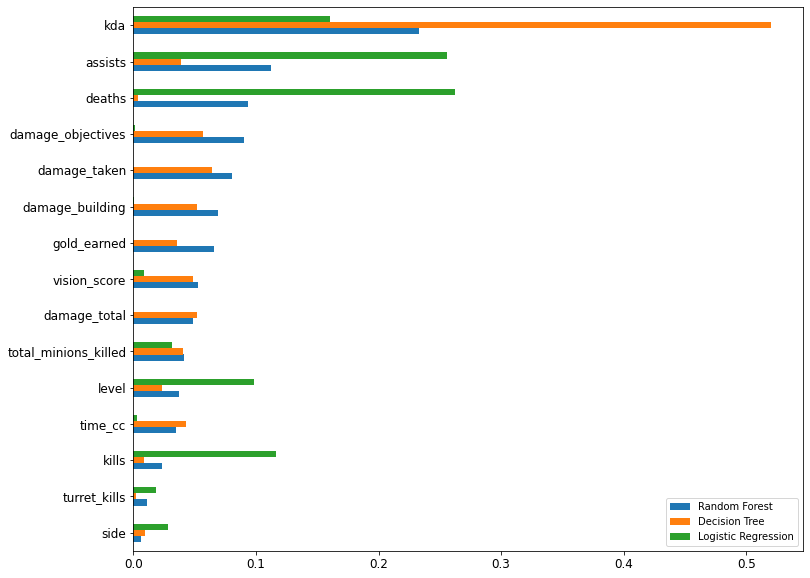

In [ ]:
#feature_importances_ 변수 중요도 추출
support_feature_importance=pd.DataFrame({
    'Random Forest':support_rf_model.feature_importances_,
    'Decision Tree':support_dt_model.feature_importances_,
    'Logistic Regression':[abs(i) for i in support_log_model.coef_[0]]
},index=support_data_final.drop(columns=['result']).columns)
support_feature_importance.sort_values(by='Random Forest',ascending=True,inplace=True)

support_feature_importance.plot(kind='barh',figsize=(12,10),fontsize=12)

세 모델 모두 KDA에 중점을 두었고, 의사 결정 트리가 가장 많은 중점을 두었다.<br>로지스틱 회귀 모델은 level,assists,kills,deaths도 중점으로 두었다는 것을 볼 수 있다.

<h2>전체결과

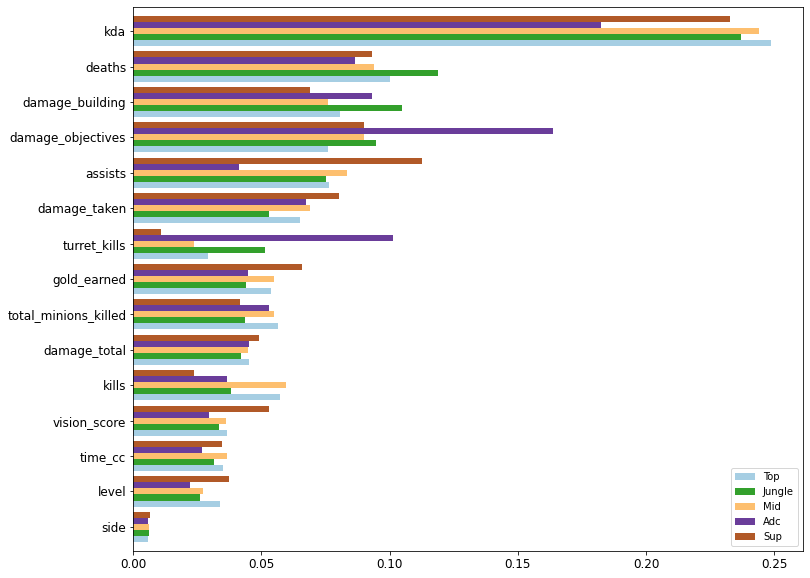

In [ ]:
#라인 포지션 별
all_feature_importance=pd.DataFrame({
    'Top':top_rf_model.feature_importances_,
    'Jungle':jungle_rf_model.feature_importances_,
    'Mid':mid_rf_model.feature_importances_,
    'Adc':adc_rf_model.feature_importances_,
    'Sup':support_rf_model.feature_importances_
},index=jungle_data_final.drop(columns=['result']).columns)

all_feature_importance.sort_values(by='Jungle',ascending=True,inplace=True)

all_feature_importance.plot(kind='barh',figsize=(12,10), width=.85, colormap='Paired', fontsize=12)

전체적으로 봤을때 KDA가 가장 중점적으로 여겨졌고 <br>
원딜 포지션의 damage_objectives가 중점적으로 여겨진 것이 눈에 띈다

In [ ]:
prediction_score_data = [['top',metrics.accuracy_score(Y_test_top, y_top_predict),
                          metrics.f1_score(Y_test_top, y_top_predict),
                          metrics.roc_auc_score(Y_test_top, y_top_predict)],
                         ['jungle',metrics.accuracy_score(Y_test_jungle, y_jungle_predict),
                          metrics.f1_score(Y_test_jungle, y_jungle_predict),
                          metrics.roc_auc_score(Y_test_jungle, y_jungle_predict)],
                         ['mid',metrics.accuracy_score(Y_test_mid, y_mid_predict),
                          metrics.f1_score(Y_test_mid, y_mid_predict),
                          metrics.roc_auc_score(Y_test_mid, y_mid_predict)],
                         ['adc',metrics.accuracy_score(Y_test_adc, y_adc_predict),
                          metrics.f1_score(Y_test_adc, y_adc_predict),
                          metrics.roc_auc_score(Y_test_adc, y_adc_predict)],
                         ['sup',metrics.accuracy_score(Y_test_support, y_support_predict),
                          metrics.f1_score(Y_test_support, y_support_predict),
                          metrics.roc_auc_score(Y_test_support, y_support_predict)]]

all_prediction_scores = pd.DataFrame(prediction_score_data, columns=['포지션', 'Accuracy Score', 'F1 Score', 'ROC-AUC Score'])
all_prediction_scores

,포지션,Accuracy Score,F1 Score,ROC-AUC Score
0,top,0.825328,0.838710,0.823242
1,jungle,0.865217,0.871369,0.867931
2,mid,0.818584,0.791878,0.814139
3,adc,0.911504,0.913043,0.911677
4,sup,0.865801,0.863436,0.869234
